# Video Conversion & Analysis

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook converts videos into a data structure for use in other notebooks. Given a folder of videos, store the coordinates of each video frame in a data structure for later analysis (see output). Further, some data analysis of the videos are done.

INPUT: video folder

OUTPUT: list of tuples with the form - (label, [ {'frames': frame_number (int), 'coordinates': {x1, y1.,..(all the keypoints)} }])

## TOC:
0. [Setup](#0.-Import-Libraries-&-Setup)
1. [Capture & Store Frames in DS](#1.-Capture-&-Store-Frames)
2. [Save & Load DS From Local Storage](#2.-Save-&-Load-Frames)
3. [Visualise Data](#3.-Visualise-Data)

# 0. Import Libraries & Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cv2
import mediapipe as mp

import math

import os

from sklearn.model_selection import train_test_split

import pickle

# 1. Capture & Store Frames

In [2]:
all_landmarks = [] # List of dictionaries storing all the landmarks for every frame of one video

def label_landmarks(frame_number, landmarks):
    unboxed_landmarks = {}

    for i in range(33):
        unboxed_landmarks['x' + str(i)] = landmarks.landmark[i].x
        unboxed_landmarks['y' + str(i)] = landmarks.landmark[i].y
        unboxed_landmarks['z' + str(i)] = landmarks.landmark[i].z
        
    all_landmarks.append({ 'frame': frame_number, 'coordinates': unboxed_landmarks })

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

all_videos = [] # List of tuples - get the label from the file

directory = os.fsencode('overhead-press-videos') # Folder of videos

exit = False

for file in os.listdir(directory):
    frame_count = 1
    filename = os.fsdecode(file)
    cap = cv2.VideoCapture('overhead-press-videos/' + filename)
    with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

        while cap.isOpened():
            ret, image = cap.read()

            if ret == False:
                break
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            k = cv2.waitKey(1)
            if results.pose_landmarks != None:
                label_landmarks(frame_count, results.pose_landmarks) # store the landmarks frame by frame
                frame_count += 1
                
            if cv2.waitKey(10) & 0xFF == ord('q'):
                exit = True
                break

            cv2.imshow("output", image)

        cap.release()
        cv2.destroyAllWindows()
        
        name = None
        
        if 'good' in filename:
            name = 'good'
        elif 'back' in filename:
            name = 'back'
        elif 'forward' in filename:
            name = 'forward'
        elif 'knees' in filename:
            name = 'knees'
        
        # Save the list of frames to coordinates in all_videos and then go onto next video
        tup = (name, all_landmarks.copy())
        all_videos.append(tup)
        all_landmarks.clear()
        if exit == True:
            break

# 2. Save & Load Frames

In [4]:
pickle.dump(all_videos, open('all-overhead-press.dump', 'wb'))

In [81]:
all_videos = pickle.load(open('all-overhead-press.dump', 'rb'))
print(len(all_videos))

134


# 3. Visualise Data

In [82]:
# The list we want to convert has format: [{'frame': num, 'coordinates': {'x1'...'z33'}}]
# INPUT: list of the frames to coordinates for one video
# OUTPUT: DataFrame of the list
def convert_list_to_df(list_to_convert):
    d = {'frame': []}
    for i in range(33):
        d['x' +  str(i)] = []
        d['y' +  str(i)] = []
        d['z' +  str(i)] = []
    
    for frame in list_to_convert:
        d['frame'].append(frame['frame'])
        for j in range(33):
            d['x' +  str(j)].append(frame['coordinates']['x' + str(j)])
            d['y' +  str(j)].append(frame['coordinates']['y' + str(j)])
            d['z' +  str(j)].append(frame['coordinates']['z' + str(j)])
    return d

Lets set aside the videos for training and testing so we can spot trends in just the training set. The same seed (random_state value) is used in f1-gen-heuristic notebook so the corresponding testing set is created.

In [83]:
all_videos, _, _, _ = train_test_split(all_videos, all_videos, test_size=0.33, random_state=42)
print(len(all_videos))

89


Now, lets take 4 examples from the training dataset. A good example, an example that has a bent back in the movemenet, an example where the knees are used and an example where the bar is pushed forward.

We put the list of frames to coordinates in a DataFrame for analysis.

In [84]:
# Display what video is at each index
for i in range(len(all_videos)):
    print(str(i) + '. ' +  all_videos[i][0])

0. knees
1. good
2. back
3. good
4. knees
5. forward
6. back
7. knees
8. back
9. knees
10. back
11. good
12. knees
13. good
14. knees
15. forward
16. knees
17. knees
18. back
19. back
20. back
21. back
22. good
23. forward
24. back
25. knees
26. knees
27. good
28. good
29. forward
30. forward
31. good
32. forward
33. forward
34. back
35. knees
36. good
37. forward
38. good
39. good
40. good
41. knees
42. knees
43. good
44. back
45. good
46. knees
47. good
48. knees
49. good
50. good
51. back
52. knees
53. good
54. back
55. good
56. good
57. knees
58. knees
59. back
60. good
61. knees
62. knees
63. good
64. back
65. back
66. good
67. good
68. forward
69. knees
70. back
71. forward
72. back
73. good
74. good
75. good
76. good
77. good
78. knees
79. good
80. knees
81. good
82. good
83. forward
84. knees
85. good
86. forward
87. good
88. good


In [85]:
df_back = pd.DataFrame(convert_list_to_df(all_videos[64][1]))
all_videos[64][0]

'back'

In [86]:
df_good = pd.DataFrame(convert_list_to_df(all_videos[55][1]))
all_videos[55][0]

'good'

In [87]:
df_knees = pd.DataFrame(convert_list_to_df(all_videos[80][1]))
all_videos[80][0]

'knees'

In [88]:
df_forward = pd.DataFrame(convert_list_to_df(all_videos[15][1]))
all_videos[15][0]

'forward'

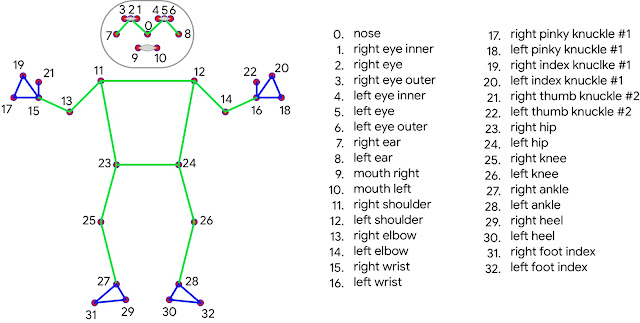

In [89]:
# Plot a 3D graph for the movement of a keypoint in the x and y direction in each frame, using the 4 examples videos
# INPUT: keypoint we want to track (int) and the title of the graph (str)
# OUTPUT: 3D graph
def gen_3d_graph(keypoint, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(df_back.frame, df_back['x'+str(keypoint)], df_back['y'+str(keypoint)], 'red')
    ax.plot3D(df_good.frame, df_good['x'+str(keypoint)], df_good['y'+str(keypoint)], 'green')
    ax.plot3D(df_knees.frame, df_knees['x'+str(keypoint)], df_knees['y'+str(keypoint)], 'blue')
    ax.plot3D(df_forward.frame, df_forward['x'+str(keypoint)], df_forward['y'+str(keypoint)], 'purple')
    ax.legend(['Back', 'Good', 'Knees', 'Forward'])
    ax.set_title(title)
    ax.set_xlabel('Frame Number')
    ax.set_ylabel('x')
    ax.set_zlabel('y')

I set up the helper function above to draw graphs.

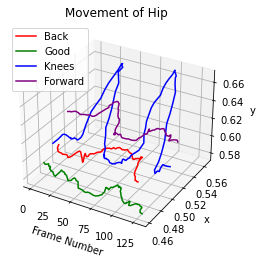

In [90]:
gen_3d_graph(23, 'Movement of Hip')

Figure shows the movement of the hip coordinate in each frame. There is a clear spike in the blue curve which indicates that the knees are bent during the movement. The green curve is also separated from the other curves.

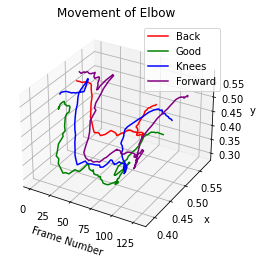

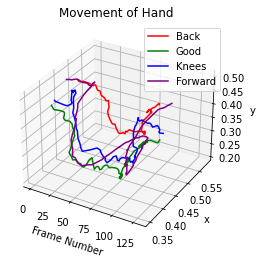

In [91]:
gen_3d_graph(13, 'Movement of Elbow')
gen_3d_graph(15, 'Movement of Hand')

In [92]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers (ints)
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [93]:
df_back['angle'] = df_back.apply(lambda row: get_angle(row, 11, 13, 15), axis=1)
df_back[['angle']]

,angle
0,28.269496
1,26.909521
2,25.802131
3,23.166209
4,21.894297
...,...
92,17.622263
93,16.159493
94,16.355966
95,16.965170


Using the get_angle function, we can get the angle between 3 keypoints in each frame of the df. I made another helper function to plot the graphs below.

In [94]:
# Plot a 2D graph to show how the angle between 3 keypoints changes in each frame, using the 4 example videos
# INPUT: the 3 keypoints of the angle we want to track (3 ints) and the title of the graph (str)
# OUTPUT: 2D graph
def gen_2d_graph(keypoint_1, keypoint_2, keypoint_3, title):
    df_back['angle'] = df_back.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    ax = df_back.plot(kind='scatter', x='frame', y='angle', color='red')

    df_good['angle'] = df_good.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_good.plot(ax=ax, kind='scatter', x='frame', y='angle', color='green')

    df_knees['angle'] = df_knees.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_knees.plot(ax=ax, kind='scatter', x='frame', y='angle', color='blue')

    df_forward['angle'] = df_forward.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_forward.plot(ax=ax, kind='scatter', x='frame', y='angle', color='purple')

    ax.set_title(title)
    ax.legend(['Back', 'Good', 'Knees', 'Forward'])

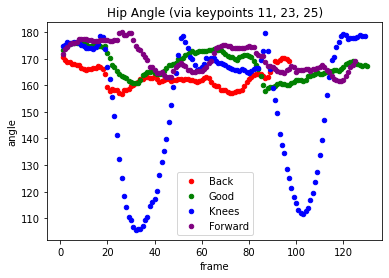

In [95]:
gen_2d_graph(11, 23, 25, 'Hip Angle (via keypoints 11, 23, 25)')

There is a clear dip in blue curve. Therefore, we can check if the knees are being used in the movement by checking if the hip angle dips below 145 degrees.

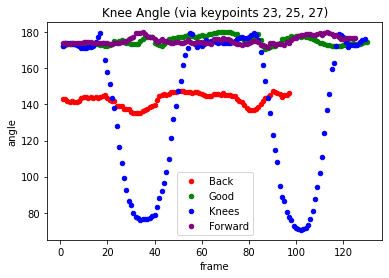

In [96]:
gen_2d_graph(23, 25, 27, 'Knee Angle (via keypoints 23, 25, 27)')

Again, the blue curve appears easily separable, but also the red curve.

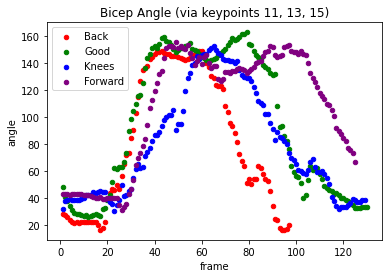

In [97]:
gen_2d_graph(11, 13, 15, 'Bicep Angle (via keypoints 11, 13, 15)')
plt.savefig('op-bicep.svg', bbox_inches='tight')

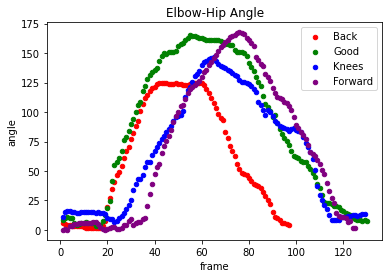

In [98]:
gen_2d_graph(13, 11, 23, 'Elbow-Hip Angle')
plt.savefig('op-elbow-hip.svg', bbox_inches='tight')

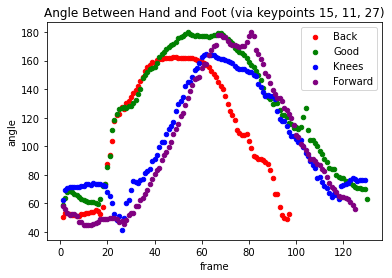

In [99]:
gen_2d_graph(15, 11, 27, 'Angle Between Hand and Foot (via keypoints 15, 11, 27)')
plt.savefig('op-hand-foot.svg', bbox_inches='tight')

Ah, that seems quite useless.

So far, it looks like we have a way to differentiate the blue and green curve. To differentinate the purple curve we could look at the x difference between two keypoints, as we saw the purple curve's x-coordinate changed a lot in the 3D graph plotted earlier.

In [100]:
# Get the x differnece between two keypoints in a frame
# INPUT: frame (dictionary of keypoints to coordinates) and the 2 keypoints
# OUPUT: absolute value of the difference
def get_x_difference(frame, keypoint_1, keypoint_2):
    return abs(frame['x'+str(keypoint_1)] - frame['x'+str(keypoint_2)])

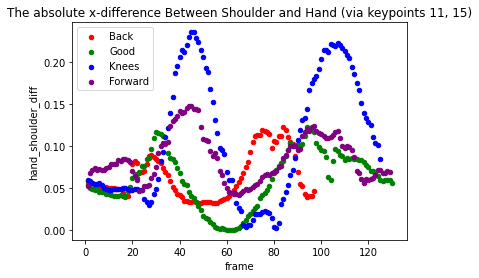

In [101]:
df_back['hand_shoulder_diff'] = df_back.apply(lambda row: get_x_difference(row, 11, 15), axis=1)
ax = df_back.plot(kind='scatter', x='frame', y='hand_shoulder_diff', color='red')

df_good['hand_shoulder_diff'] = df_good.apply(lambda row: get_x_difference(row, 11, 15), axis=1)
df_good.plot(ax=ax, kind='scatter', x='frame', y='hand_shoulder_diff', color='green')

df_forward['hand_shoulder_diff'] = df_forward.apply(lambda row: get_x_difference(row, 11, 15), axis=1)
df_forward.plot(ax=ax, kind='scatter', x='frame', y='hand_shoulder_diff', color='blue')

df_knees['hand_shoulder_diff'] = df_knees.apply(lambda row: get_x_difference(row, 11, 15), axis=1)
df_knees.plot(ax=ax, kind='scatter', x='frame', y='hand_shoulder_diff', color='purple')

ax.set_title('The absolute x-difference Between Shoulder and Hand (via keypoints 11, 15)')
ax.legend(['Back', 'Good', 'Knees', 'Forward'])

plt.savefig('op-shoulder-to-hand.svg', bbox_inches='tight')
plt.show()

Ah, this seems quite useless.

Lets now look at the whole training set.

In [102]:
back_dfs = []
knees_dfs = []
good_dfs = []
forward_dfs = []

for vid in all_videos:
    df = pd.DataFrame(convert_list_to_df(vid[1]))
    if vid[0] == 'back':
        back_dfs.append(df)
    elif vid[0] == 'knees':
        knees_dfs.append(df)
    elif vid[0] == 'forward':
        forward_dfs.append(df)
    else:
        good_dfs.append(df)

In [103]:
df_back_concat = pd.concat(back_dfs)
df_knees_concat = pd.concat(knees_dfs)
df_good_concat = pd.concat(good_dfs)
df_forward_concat = pd.concat(forward_dfs)

df_back_means = (df_back_concat.groupby(df_back_concat.frame)).mean()
df_knees_means = (df_knees_concat.groupby(df_knees_concat.frame)).mean()
df_good_means = (df_good_concat.groupby(df_good_concat.frame)).mean()
df_forward_means = (df_forward_concat.groupby(df_forward_concat.frame)).mean()

In [104]:
df_good_means

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
frame,,,,,,,,,,,,,,,,,,,,,
1,0.439567,0.324185,-0.048271,0.460375,0.313460,-0.092994,0.464478,0.313925,-0.093071,0.468771,...,-0.161649,0.531531,0.843926,0.576904,0.415057,0.889245,-0.334340,0.431247,0.844224,0.508310
2,0.439549,0.326156,-0.054270,0.460502,0.315077,-0.098555,0.464672,0.315420,-0.098637,0.469028,...,-0.139423,0.530577,0.844921,0.538128,0.414073,0.889169,-0.311739,0.428678,0.845926,0.468339
3,0.439335,0.326847,-0.050501,0.460352,0.315696,-0.094798,0.464553,0.316012,-0.094879,0.468925,...,-0.133739,0.530131,0.844402,0.529827,0.413468,0.889114,-0.305593,0.427609,0.846949,0.459081
4,0.438792,0.327504,-0.050206,0.459780,0.316284,-0.094933,0.463988,0.316586,-0.095012,0.468348,...,-0.131550,0.529226,0.846270,0.525036,0.413336,0.888992,-0.301721,0.427173,0.846971,0.453665
5,0.438582,0.327752,-0.048853,0.459573,0.316480,-0.094151,0.463782,0.316780,-0.094229,0.468134,...,-0.135419,0.529268,0.847338,0.514033,0.413391,0.889014,-0.307495,0.427116,0.847287,0.443442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.454493,0.314150,-0.108858,0.476935,0.304792,-0.154450,0.480634,0.305618,-0.154523,0.484518,...,-0.054906,0.530493,0.842884,0.566496,0.417570,0.882058,-0.228791,0.427828,0.838601,0.490536
138,0.456000,0.322724,-0.102539,0.477637,0.313879,-0.149820,0.481323,0.314716,-0.149895,0.485176,...,-0.073135,0.530304,0.848247,0.561431,0.420730,0.887513,-0.246378,0.424427,0.845788,0.489064
139,0.456397,0.313554,-0.107054,0.477901,0.304851,-0.154213,0.481655,0.305749,-0.154285,0.485562,...,-0.056433,0.523564,0.834206,0.563868,0.412449,0.873581,-0.230786,0.415381,0.833181,0.492166


The DataFrame represents all the mean values of the coordinates in each frame of every video in the dataset.

In [105]:
# Plot a 2D graph to show how the angle between 3 keypoints changes in each frame, using the 4 example mistakes mean dfs
# INPUT: the 3 keypoints of the angle we want to track (3 ints), name of the angle (str) and the title of the graph (str)
# OUTPUT: 2D graph
def gen_2d_means_graph(keypoint_1, keypoint_2, keypoint_3, angle_name, title):
    df_back_means[angle_name] = df_back_means.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    ax = df_back_means.reset_index().plot(kind='scatter', x='frame', y=angle_name, color='red')

    df_good_means[angle_name] = df_good_means.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_good_means.reset_index().plot(ax=ax, kind='scatter', x='frame', y=angle_name, color='green')

    df_knees_means[angle_name] = df_knees_means.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_knees_means.reset_index().plot(ax=ax, kind='scatter', x='frame', y=angle_name, color='blue')
    
    df_forward_means[angle_name] = df_forward_means.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_forward_means.reset_index().plot(ax=ax, kind='scatter', x='frame', y=angle_name, color='purple')
    
    ax.set_title(title)
    ax.legend(['Back', 'Good', 'Knees', 'Forward'])

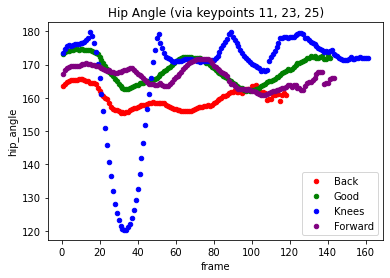

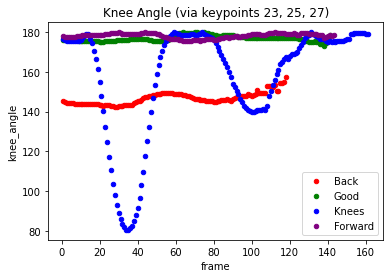

In [106]:
gen_2d_means_graph(11, 23, 25, 'hip_angle', 'Hip Angle (via keypoints 11, 23, 25)')
plt.savefig('op-hip-means.svg', bbox_inches='tight')

gen_2d_means_graph(23, 25, 27, 'knee_angle', 'Knee Angle (via keypoints 23, 25, 27)')
plt.savefig('op-knee-means.svg', bbox_inches='tight')

The pattern still remains the same as before.

    1. In a video where the knees are bent, the hip angle dips below 150 degrees or we can check if the knee angle dips below 120 degrees.
    2. The red line looks separable too.